In this example we want to change the model to use MACE and furthermore, do some ensembling.
To make this possible, it is important to mention that the graph is stored in two files:
- `dvc.yaml` contains the graph definition and when ever we add a new Node it will be added here.
- `zntrack.json` contains additiona Node information used by ZnTrack

If we modify the graph we can mostly rely on the `dvc run cache` to restore our results.
Therefore, we will remove the files `dvc.yaml`, `params.yaml` and `zntrack.json` as well as the `nodes` directory first.

Most of the content will be re-created when running `project.run()` again.

In [1]:
!rm dvc.yaml params.yaml zntrack.json
!rm -rf nodes/

In [2]:
import ipsuite as ips

2023-04-05 14:25:29.344795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 14:25:29.415835: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 14:25:30.020877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-05 14:25:30.020915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

2023-04-05 14:25:31,144 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
with ips.Project() as project:
    data = ips.AddData(file="KCl1650K.extxyz")
    test_data = ips.configuration_selection.UniformEnergeticSelection(
        data=data, n_configurations=500, name="test_data"
    )
    # we have now given the Nodes a "name" attribute to uniquly identify them
    train_data = ips.configuration_selection.RandomSelection(
        data=data,
        n_configurations=100,
        exclude_configurations=test_data.exclude_configurations,
        name="train_data",
    )
    validate_data = ips.configuration_selection.RandomSelection(
        data=train_data.excluded_atoms,
        n_configurations=10,
        name="validate_data",
    )
    model = ips.models.MACE(
        data=train_data,
        test_data=validate_data,
        max_num_epochs=50,
        name="model_1",
        seed=1,
    )
    prediction = ips.analysis.PredictWithModel(model=model, data=test_data)
    analysis = ips.analysis.AnalysePrediction(data=prediction)
project.run()


Running DVC command: 'stage add --name AddData --force ...'
Running DVC command: 'stage add --name test_data --force ...'
Running DVC command: 'stage add --name train_data --force ...'
Running DVC command: 'stage add --name validate_data --force ...'
Running DVC command: 'stage add --name model_1 --force ...'
Running DVC command: 'stage add --name PredictWithModel --force ...'
Running DVC command: 'stage add --name AnalysePrediction --force ...'
Running DVC command: 'repro'


We can now invesitage our Model.

analyse.load()
print(analyse.energy)
print(analyse.forces)

analyse.get_plots()

We can use `dvc dag --mermaid` to display the graph that was created for us:

[![](https://mermaid.ink/img/pako:eNp9ktFKwzAUhl9l5Hobdq7r6IUgzqs5EL0QNDIOzakNpMlI07k69u6edhmytNir5v8-kvzhHFlmBLKU5cp8ZwVYN3p64XrkP00w-uDsXogVOODs85rNWqZBNRU-WxQyc9LonnVL1vpBRYv4Zj3Fgzs0P1Oxz3renDy_zZt0xYYi1ZNiksqWbKMeWxBzWLmtGLps0lILUg_jJeE9KEkQh41oMrnrjhmOk6C1j6OgpI9nQS0fz4NG_8fBkYmP4-F4GRS-2GzMSrQlSEGDcGwleqgCS-QspV-BOdTKccb1idR6177Qo5DOWJY6W-OYQe3Ma6Ozy_rsrCR8WShZmoOqKN2Bfjfmb43dHpvzAHZzePoFxj7EdA?type=png)](https://mermaid.live/edit#pako:eNp9ktFKwzAUhl9l5Hobdq7r6IUgzqs5EL0QNDIOzakNpMlI07k69u6edhmytNir5v8-kvzhHFlmBLKU5cp8ZwVYN3p64XrkP00w-uDsXogVOODs85rNWqZBNRU-WxQyc9LonnVL1vpBRYv4Zj3Fgzs0P1Oxz3renDy_zZt0xYYi1ZNiksqWbKMeWxBzWLmtGLps0lILUg_jJeE9KEkQh41oMrnrjhmOk6C1j6OgpI9nQS0fz4NG_8fBkYmP4-F4GRS-2GzMSrQlSEGDcGwleqgCS-QspV-BOdTKccb1idR6177Qo5DOWJY6W-OYQe3Ma6Ozy_rsrCR8WShZmoOqKN2Bfjfmb43dHpvzAHZzePoFxj7EdA)

We will now train 4 more models to generate an Ensemble which we can use to predict with some uncertainty.

In [4]:
models = [model]
with project:
    for idx in range(2, 6):
        models.append(
            ips.models.MACE(
                data=train_data,
                test_data=validate_data,
                max_num_epochs=50,
                seed=idx,
                name=f"model_{idx}",
            )
        )
    ensemble_model = ips.models.EnsembleModel(models=models, name="ensemble_model")
    ensemble_prediction = ips.analysis.PredictWithModel(
        model=ensemble_model, data=test_data, name="ensemble_prediction"
    )
    ensemble_analysis = ips.analysis.AnalysePrediction(
        data=ensemble_prediction, name="ensemble_analysis"
    )
project.run()


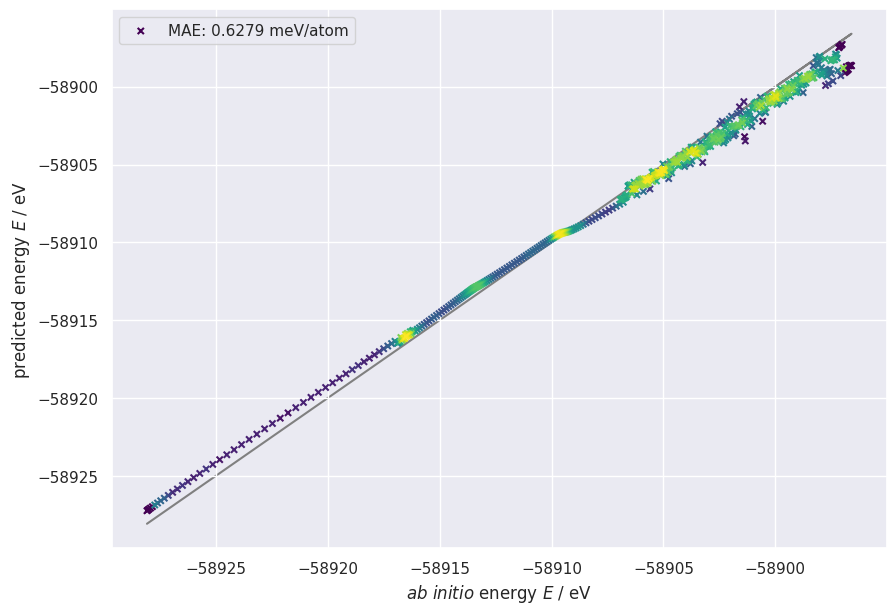

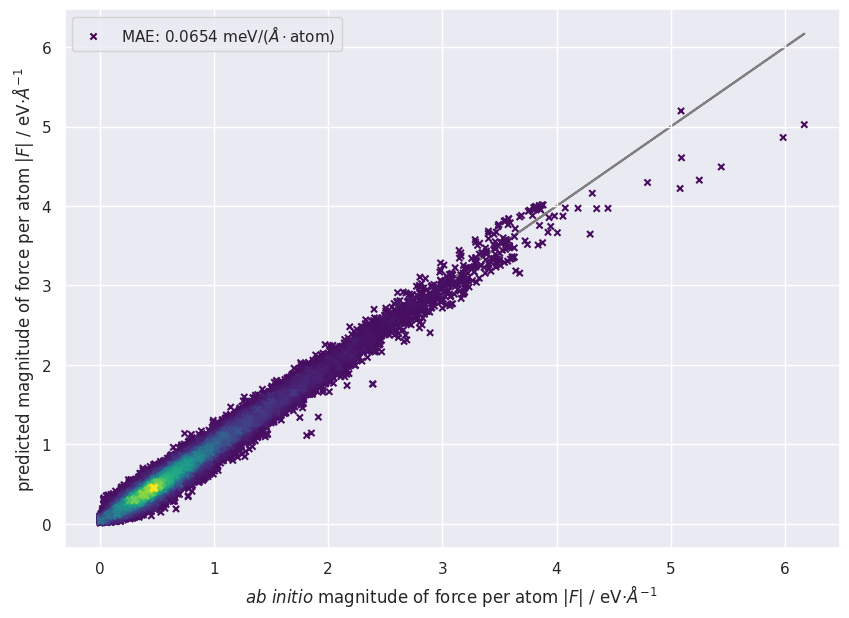

In [5]:
ensemble_analysis.load()
ensemble_analysis.get_plots()

We can now compare the metrics for a single Model or the mean of the combined predictions.

In [6]:
analysis.load()

In [7]:
print(analysis.energy)
print(ensemble_analysis.energy)

{'rmse': 0.8894759698426303, 'mae': 0.7299131207371538, 'max': 2.503074162210396, 'lp4': 0.011139526970185012, 'pearsonr': 0.9984550534865273}
{'rmse': 0.7645978517649176, 'mae': 0.6278524194699566, 'max': 2.2089436319001834, 'lp4': 0.009689683073219876, 'pearsonr': 0.9985963971694386}


In [8]:
print(analysis.forces)
print(ensemble_analysis.forces)

{'rmse': 0.09309140642036187, 'mae': 0.06997889950744765, 'max': 1.668132486783617, 'lp4': 5.0130417499392916e-05, 'pearsonr': 0.9816315035125179}
{'rmse': 0.08618419085026167, 'mae': 0.0654169609706986, 'max': 1.1445681499379594, 'lp4': 4.064163828238075e-05, 'pearsonr': 0.9844360000404122}


This results in the following graph:

[![](https://mermaid.ink/img/pako:eNp1lF1PwjAUhv8K6TWQdax87MLEiFdIYvTCRGdIXQ_SpOvI1iFI-O92OCa2O7tanudNe3LOSY8kzQWQmKxV_pVueGF6D0-J7jWftpK-JeRWiDk3PCHv_11YO83VoYTHAoRMjcy1lxrZ1OJO0TELFkPYm_3heyh2qZeLbK455kWazdIi5YWYDYEuIftQsOLnu2XppcbXqazzoMl1ZItXP7W58wkr6rlZ60LP0aCVI1_SVka-DFvJfFl300BpVqJrIrRuoim41Iiv-7fjSloLSGQwuPm9CeGRM94Ld6bZ4NCZTIMnzjQazJzmNzjqxmNnHN2YBginCA8RPuqupuUThLsdo5feTBE-QzgNMEExEWKCuYuB1MSQmhhWE8NqakVI-iSDIuNS2KfnWMfs0m4gg4TE9lfAmlfKJCTRJxvllcmfDzolsSkq6JNqWy_vXPLPgmckXnNVtvReSJMXl-SW69c8_8vA2S5_n7zzy3f6AbnqcMk?type=png)](https://mermaid.live/edit#pako:eNp1lF1PwjAUhv8K6TWQdax87MLEiFdIYvTCRGdIXQ_SpOvI1iFI-O92OCa2O7tanudNe3LOSY8kzQWQmKxV_pVueGF6D0-J7jWftpK-JeRWiDk3PCHv_11YO83VoYTHAoRMjcy1lxrZ1OJO0TELFkPYm_3heyh2qZeLbK455kWazdIi5YWYDYEuIftQsOLnu2XppcbXqazzoMl1ZItXP7W58wkr6rlZ60LP0aCVI1_SVka-DFvJfFl300BpVqJrIrRuoim41Iiv-7fjSloLSGQwuPm9CeGRM94Ld6bZ4NCZTIMnzjQazJzmNzjqxmNnHN2YBginCA8RPuqupuUThLsdo5feTBE-QzgNMEExEWKCuYuB1MSQmhhWE8NqakVI-iSDIuNS2KfnWMfs0m4gg4TE9lfAmlfKJCTRJxvllcmfDzolsSkq6JNqWy_vXPLPgmckXnNVtvReSJMXl-SW69c8_8vA2S5_n7zzy3f6AbnqcMk)